# Settings

In [51]:
#@title imports
import sys, csv
from dataclasses import dataclass

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 2]

In [16]:
#@title parameters
@dataclass
class G:
    SPLIT_TIME = 3000
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Utils

In [44]:
#@title plot_series
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # check if there are more than two series to plot
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)

    # labels, legend, title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)

    plt.grid(True)
    plt.show()

In [15]:
#@title windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows
    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method
    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    dataset = tf.data.Dataset.from_tensor_slices(series)                     # generate dataset
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)  # create windows
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten the windows by putting its elements in a single batch
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))          # create tuples with features and labels
    dataset = dataset.shuffle(shuffle_buffer)                                # shuffle windows
    dataset = dataset.batch(batch_size).prefetch(1)                          # create batches of window

    return dataset

In [20]:
#@title adjust_learning_rate
def adjust_learning_rate(dataset, model, loss_function, verbose=2):
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=verbose)

    return history

In [27]:
#@title plot_learning_rate
def plot_learning_rate(history, zoom=[1e-7, 1e-4, 0, 20]):
  lrs = 1e-8 * (10 ** (np.arange(100) / 20))  # learning rate array

  plt.figure(figsize=(10, 2))
  plt.subplot(1, 2, 1)
  plt.grid(True)
  plt.semilogx(lrs, history.history["loss"]) # plot the loss in log scale
  plt.tick_params('both', length=10, width=1, which='both') # increase tickmarks size
  plt.axis([1e-8, 1e-3, 0, 50]) # set plot boundaries

  # zoom-in
  plt.subplot(1, 2, 2)
  plt.grid(True)
  plt.semilogx(lrs, history.history["loss"])
  plt.tick_params('both', length=10, width=1, which='both')
  plt.axis(zoom)

  plt.tight_layout()  # to avoid overlapping
  plt.show()

In [48]:
#@title model_forecast
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows
    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size
    Returns:
      forecast (numpy array) - array containing predictions
    """
    ds = tf.data.Dataset.from_tensor_slices(series)           # generate a TF Dataset from the series values
    ds = ds.window(window_size, shift=1, drop_remainder=True) # window the data but only take those with the specified size
    ds = ds.flat_map(lambda w: w.batch(window_size))          # flatten the windows by putting its elements in a single batch
    ds = ds.batch(batch_size).prefetch(1)                     # create batches of windows
    forecast = model.predict(ds)                              # get predictions on the entire dataset

    return forecast

# Dataset

In [4]:
# #@title download dataset
# %%capture
# !wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

In [5]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


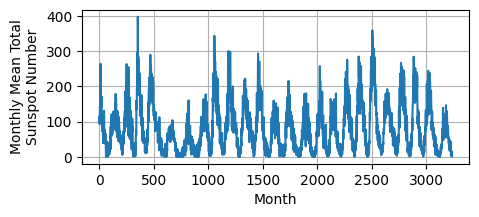

In [11]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      time_step.append(int(row[0]))
      sunspots.append(float(row[2]))

time = np.array(time_step)
series = np.array(sunspots)

plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total\nSunspot Number')

In [17]:
# split dataset
time_train = time[:G.SPLIT_TIME]
x_train = series[:G.SPLIT_TIME]

time_valid = time[G.SPLIT_TIME:]
x_valid = series[G.SPLIT_TIME:]

In [18]:
# create windowed dataset
train_set = windowed_dataset(x_train, G.WINDOW_SIZE, G.BATCH_SIZE, G.SHUFFLE_BUFFER_SIZE)

# DNN

In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

## Model

In [39]:
def create_dnn_model(window_size):
  return tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [40]:
model_dnn_tune = create_dnn_model(G.WINDOW_SIZE)

model_dnn_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                930       
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


## Tune learning rate

In [ ]:
history_dnn_tune = adjust_learning_rate(train_set, model_dnn_tune, tf.keras.losses.Huber())

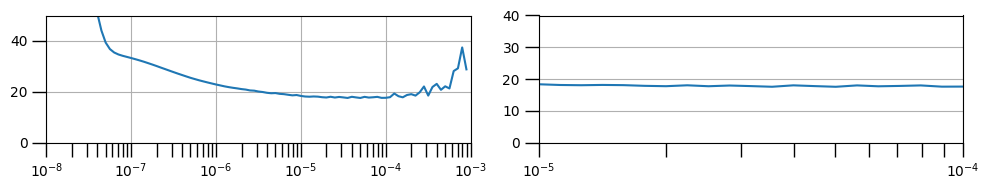

In [28]:
plot_learning_rate(history_dnn_tune, [1e-5, 1e-4, 0, 40])

## Train

In [42]:
# tf.keras.backend.clear_session()

model_dnn = create_dnn_model(G.WINDOW_SIZE)

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model_dnn.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history_dnn = model_dnn.fit(train_set,epochs=100, verbose=0)

## Predict

8/8 [==============================] - 0s 16ms/step


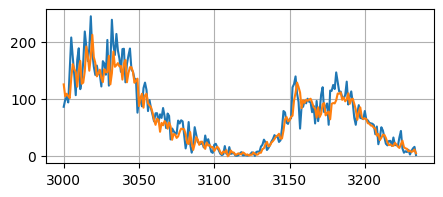

MAE: 15.018946


In [50]:
forecast_series = series[G.SPLIT_TIME-G.WINDOW_SIZE:-1]
forecast = model_forecast(model_dnn, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze() # drop single dimensional axis

plot_series(time_valid, (x_valid, results))
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Combined layers

In [ ]:
sys.exit("Execution stopped. Please run cells selectively.")

## Model

In [72]:
def create_uncompiled_model(window_size):
  return tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [53]:
model_tune = create_uncompiled_model(G.WINDOW_SIZE)

model_tune.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_21 (Dense)            (None, 30)                1950      
                                                                 
 dense_22 (Dense)            (None, 10)                310       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                

## Tune learning rate

In [ ]:
lr_history = adjust_learning_rate(train_set, model_tune, tf.keras.losses.Huber())

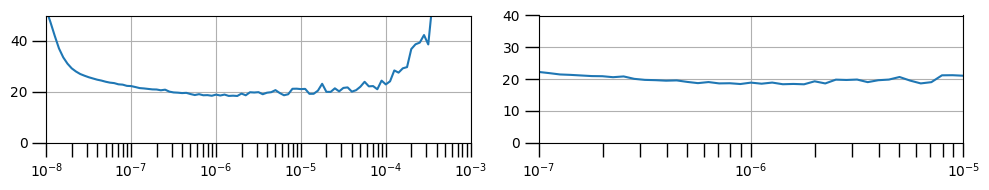

In [56]:
plot_learning_rate(lr_history, [1e-7, 1e-5, 0, 40])

## Train

In [57]:
# tf.keras.backend.clear_session()

model = create_uncompiled_model(G.WINDOW_SIZE)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set,epochs=100, verbose=0)

## Predict

8/8 [==============================] - 0s 34ms/step


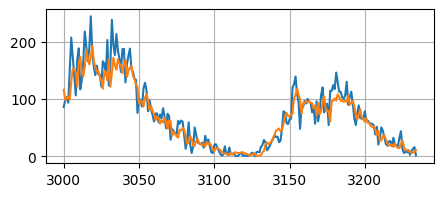

MAE: 14.697375


In [64]:
forecast_series = series[G.SPLIT_TIME-G.WINDOW_SIZE:-1]
forecast = model_forecast(model, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze() # drop single dimensional axis

plot_series(time_valid, (x_valid, results))
print('MAE:', tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Another way to dynamically set the learning rate.

At some point, the static learning rate we set might no longer be the optimal one when the model has been learning for some time. We may want to decrease it some more to see better improvements. One way to do that is to have our training loop gradually decay the learning rate per epoch. We can pass in a lambda function similar like the one we did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

In [73]:
model_2 = create_uncompiled_model(G.WINDOW_SIZE)

initial_learning_rate=1e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model_2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history_2 = model_tune_2.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 6s 67ms/step - loss: 20.5188 - mae: 21.0111
Epoch 2/100
93/93 [==============================] - 4s 45ms/step - loss: 20.4995 - mae: 20.9938
Epoch 3/100
93/93 [==============================] - 4s 45ms/step - loss: 20.6158 - mae: 21.1094
Epoch 4/100
93/93 [==============================] - 5s 49ms/step - loss: 20.1585 - mae: 20.6517
Epoch 5/100
93/93 [==============================] - 4s 44ms/step - loss: 20.3689 - mae: 20.8621
Epoch 6/100
93/93 [==============================] - 5s 56ms/step - loss: 20.2043 - mae: 20.6971
Epoch 7/100
93/93 [==============================] - 4s 42ms/step - loss: 20.1444 - mae: 20.6368
Epoch 8/100
93/93 [==============================] - 4s 43ms/step - loss: 20.1702 - mae: 20.6627
Epoch 9/100
93/93 [==============================] - 5s 47ms/step - loss: 20.2210 - mae: 20.7136
Epoch 10/100
93/93 [==============================] - 4s 43ms/step - loss: 20.0179 - mae: 20.5109
Epoch 11/100
93/93 [=========

8/8 [==============================] - 1s 22ms/step


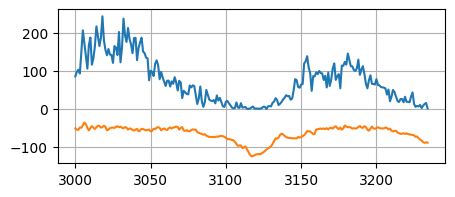

137.14287

In [74]:
forecast_series = series[G.SPLIT_TIME-G.WINDOW_SIZE:-1]
forecast = model_forecast(model_2, forecast_series, G.WINDOW_SIZE, G.BATCH_SIZE)
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()